In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch_geometric.transforms as T

import fish_models
import robofish.io

from SwarmNet import create_swarm_dataset, train_SwarmNet, save_model, load_model, Pose_and_View_SwarmNet, CouzinModel

# Data

In [2]:
full_path = fish_models.raw_data('pascal_vanilla_couzin')
full_path

WindowsPath('c:/users/olaf/onedrive/öffentlich/master/researchinternship/fish_models/storage/raw_data/pascal_vanilla_couzin')

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\train"

dset = fish_models.IoDataset(data_folder, raycast, output_strings=["poses", "actions", "views"], max_files=500)

data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\test"

dset_test = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\validation"

dset_val = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50,
)

Loading data from 500 files.


100%|████████████████████████████████████████| 500/500 [00:07<00:00, 66.17it/s]


None
Calculating views from 500 files.


100%|████████████████████████████████████████| 500/500 [01:25<00:00,  5.82it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 62571.67it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 500/500 [00:00<00:00, 50014.36it/s]


Reducing shape of views.


100%|██████████████████████████████████████| 500/500 [00:00<00:00, 7465.11it/s]


Status of IoDataset:
poses	(500, 2, 199, 3):	consisting of x, y, orientation.
actions	(500, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(500, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Loading data from 50 files.


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 70.55it/s]


None
Calculating views from 50 files.


100%|██████████████████████████████████████████| 50/50 [00:07<00:00,  6.87it/s]


Reducing shape of poses.


100%|███████████████████████████████████████| 50/50 [00:00<00:00, 25022.69it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 50/50 [00:00<00:00, 25025.68it/s]


Reducing shape of views.


100%|████████████████████████████████████████| 50/50 [00:00<00:00, 6239.30it/s]


Status of IoDataset:
poses	(50, 2, 199, 3):	consisting of x, y, orientation.
actions	(50, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(50, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Loading data from 50 files.


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 70.91it/s]


None
Calculating views from 50 files.


100%|██████████████████████████████████████████| 50/50 [00:07<00:00,  6.67it/s]


Reducing shape of poses.


100%|███████████████████████████████████████| 50/50 [00:00<00:00, 25010.76it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 50/50 [00:00<00:00, 25010.76it/s]


Reducing shape of views.


100%|████████████████████████████████████████| 50/50 [00:00<00:00, 5024.44it/s]

Status of IoDataset:
poses	(50, 2, 199, 3):	consisting of x, y, orientation.
actions	(50, 2, 199, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(50, 2, 199, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.



In [4]:
BATCH_SIZE = 320
train_loader = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=None)
train_loader_filter = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=40)
test_loader = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=None)
test_loader_filter = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=40)
val_loader = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=None)
val_loader_filter = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=40)

In [5]:
del dset
del dset_test
del dset_val

# Training with different number of layers

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for n_linears in range(6, 11):
    PATH = f"pascal_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"fully: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    
    PATH = f"pascal_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"filter: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)

[Train: 0.055][Val: 0.072]: 100%|████████████| 200/200 [14:54<00:00,  4.47s/it]


fully: 6 linear layer: train loss: 0.055, val loss: 0.072


[Train: 0.055][Val: 0.074]: 100%|████████████| 200/200 [14:34<00:00,  4.37s/it]


filter: 6 linear layer: train loss: 0.055, val loss: 0.074


[Train: 0.057][Val: 0.076]: 100%|████████████| 200/200 [14:07<00:00,  4.24s/it]


fully: 7 linear layer: train loss: 0.057, val loss: 0.076


[Train: 0.062][Val: 0.083]: 100%|████████████| 200/200 [14:00<00:00,  4.20s/it]


filter: 7 linear layer: train loss: 0.062, val loss: 0.083


[Train: 0.056][Val: 0.075]: 100%|████████████| 200/200 [14:38<00:00,  4.39s/it]


fully: 8 linear layer: train loss: 0.056, val loss: 0.075


[Train: 0.061][Val: 0.076]: 100%|████████████| 200/200 [14:40<00:00,  4.40s/it]


filter: 8 linear layer: train loss: 0.061, val loss: 0.076


[Train: 0.065][Val: 0.082]: 100%|████████████| 200/200 [14:41<00:00,  4.41s/it]


fully: 9 linear layer: train loss: 0.065, val loss: 0.082


[Train: 0.074][Val: 0.088]: 100%|████████████| 200/200 [14:43<00:00,  4.42s/it]


filter: 9 linear layer: train loss: 0.074, val loss: 0.088


[Train: 0.072][Val: 0.099]: 100%|████████████| 200/200 [16:09<00:00,  4.85s/it]


fully: 10 linear layer: train loss: 0.072, val loss: 0.099


[Train: 0.074][Val: 0.094]: 100%|████████████| 200/200 [15:58<00:00,  4.79s/it]

filter: 10 linear layer: train loss: 0.074, val loss: 0.094


### Load Models again

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"pascal_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    PATH = f"pascal_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)

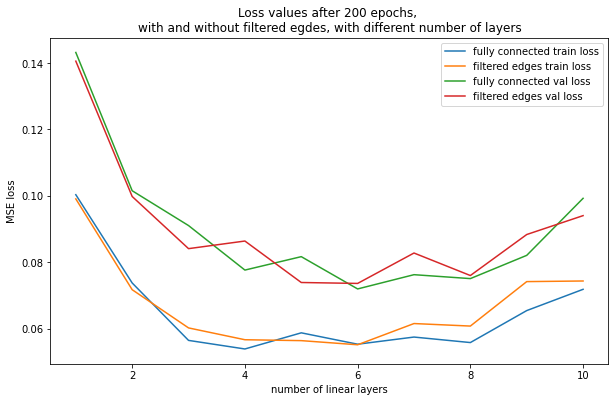

In [7]:
plt.figure(figsize=(10,6))
x = np.arange(1,11)
plt.plot(x,np.array(train_loss_list)[:, -1][::2], label="fully connected train loss")
plt.plot(x,np.array(train_loss_list)[:, -1][1::2], label="filtered edges train loss")
plt.plot(x,np.array(val_loss_list)[:, -1][::2], label="fully connected val loss")
plt.plot(x,np.array(val_loss_list)[:, -1][1::2], label="filtered edges val loss")
plt.legend()
plt.title("Loss values after 200 epochs, \nfully connected and without filtered egdes, with different number of layers")
plt.xlabel("number of linear layers")
plt.ylabel("MSE loss")
plt.show()

# Couzin Dataset

In [2]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [3]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(data_folder, raycast, output_strings=["poses", "actions", "views"], max_files=500)

data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"

dset_test = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\validation"

dset_val = fish_models.IoDataset(data_folder,raycast,output_strings=["poses", "actions", "views"],max_files=50,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:07<00:00, 24.79it/s]


None
Calculating views from 197 files.


100%|████████████████████████████████████████| 197/197 [02:25<00:00,  1.35it/s]


Reducing shape of poses.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 19677.03it/s]


Reducing shape of actions.


100%|█████████████████████████████████████| 197/197 [00:00<00:00, 28160.24it/s]


Reducing shape of views.


100%|███████████████████████████████████████| 197/197 [00:00<00:00, 267.18it/s]


Status of IoDataset:
poses	(197, 8, 749, 3):	consisting of x, y, orientation.
actions	(197, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(197, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:08<00:00,  2.78it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:23<00:00,  1.03it/s]


Reducing shape of poses.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12012.33it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 11998.01it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 282.46it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
Loading data from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:01<00:00, 21.46it/s]


None
Calculating views from 24 files.


100%|██████████████████████████████████████████| 24/24 [00:19<00:00,  1.25it/s]


Reducing shape of poses.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12016.63it/s]


Reducing shape of actions.


100%|███████████████████████████████████████| 24/24 [00:00<00:00, 12012.33it/s]


Reducing shape of views.


100%|█████████████████████████████████████████| 24/24 [00:00<00:00, 263.89it/s]


Status of IoDataset:
poses	(24, 8, 749, 3):	consisting of x, y, orientation.
actions	(24, 8, 749, 2):	consisting of speed [cm/s] and turn [rad/s].
views	(24, 8, 749, 450):	consisting of 150 fish bins, 150 fish oris and 150 wall raycasts.

Note: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them


In [4]:
BATCH_SIZE = 320
train_loader = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=None)
train_loader_filter = create_swarm_dataset(dset["poses"], dset["actions"], dset["views"], batchsize=BATCH_SIZE, filter_distance=40)
test_loader = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=None)
test_loader_filter = create_swarm_dataset(dset_test["poses"], dset_test["actions"], dset_test["views"], batchsize=BATCH_SIZE, filter_distance=40)
val_loader = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=None)
val_loader_filter = create_swarm_dataset(dset_val["poses"], dset_val["actions"], dset_val["views"], batchsize=BATCH_SIZE, filter_distance=40)

c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:523: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


In [5]:
del dset
del dset_test
del dset_val

## Training with different number of layers

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"couzin_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"fully: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)
    
    PATH = f"couzin_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                      criterion, epochs=200, device=device)
    save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)
    print(f"filter: {n_linears} linear layer: train loss: {train_losses[-1]:.3f}, val loss: {val_losses[-1]:.3f}")
    train_loss_list.append(train_losses)
    val_loss_list.append(val_losses)

[Train: 0.104][Val: 0.181]: 100%|████████████| 200/200 [22:39<00:00,  6.80s/it]


fully: 1 linear layer: train loss: 0.104, val loss: 0.181


[Train: 0.103][Val: 0.200]: 100%|████████████| 200/200 [22:55<00:00,  6.88s/it]


filter: 1 linear layer: train loss: 0.103, val loss: 0.200


[Train: 0.080][Val: 0.184]: 100%|████████████| 200/200 [22:32<00:00,  6.76s/it]


fully: 2 linear layer: train loss: 0.080, val loss: 0.184


[Train: 0.083][Val: 0.179]: 100%|████████████| 200/200 [20:06<00:00,  6.03s/it]


filter: 2 linear layer: train loss: 0.083, val loss: 0.179


[Train: 0.068][Val: 0.164]: 100%|████████████| 200/200 [21:24<00:00,  6.42s/it]


fully: 3 linear layer: train loss: 0.068, val loss: 0.164


[Train: 0.070][Val: 0.163]: 100%|████████████| 200/200 [18:07<00:00,  5.44s/it]


filter: 3 linear layer: train loss: 0.070, val loss: 0.163


[Train: 0.069][Val: 0.159]: 100%|████████████| 200/200 [18:23<00:00,  5.52s/it]


fully: 4 linear layer: train loss: 0.069, val loss: 0.159


[Train: 0.065][Val: 0.172]: 100%|████████████| 200/200 [18:13<00:00,  5.47s/it]


filter: 4 linear layer: train loss: 0.065, val loss: 0.172


[Train: 0.066][Val: 0.157]: 100%|████████████| 200/200 [18:55<00:00,  5.68s/it]


fully: 5 linear layer: train loss: 0.066, val loss: 0.157


[Train: 0.071][Val: 0.170]: 100%|████████████| 200/200 [18:57<00:00,  5.69s/it]


filter: 5 linear layer: train loss: 0.071, val loss: 0.170


[Train: 0.065][Val: 0.162]: 100%|████████████| 200/200 [19:42<00:00,  5.91s/it]


fully: 6 linear layer: train loss: 0.065, val loss: 0.162


[Train: 0.064][Val: 0.149]: 100%|████████████| 200/200 [19:54<00:00,  5.97s/it]


filter: 6 linear layer: train loss: 0.064, val loss: 0.149


[Train: 0.094][Val: 0.132]: 100%|████████████| 200/200 [20:26<00:00,  6.13s/it]


fully: 7 linear layer: train loss: 0.094, val loss: 0.132


[Train: 0.086][Val: 0.147]: 100%|████████████| 200/200 [20:31<00:00,  6.16s/it]


filter: 7 linear layer: train loss: 0.086, val loss: 0.147


[Train: 0.068][Val: 0.155]: 100%|████████████| 200/200 [21:15<00:00,  6.38s/it]


fully: 8 linear layer: train loss: 0.068, val loss: 0.155


[Train: 0.080][Val: 0.136]: 100%|████████████| 200/200 [21:15<00:00,  6.38s/it]


filter: 8 linear layer: train loss: 0.080, val loss: 0.136


[Train: 0.091][Val: 0.152]: 100%|████████████| 200/200 [22:03<00:00,  6.62s/it]


fully: 9 linear layer: train loss: 0.091, val loss: 0.152


[Train: 0.130][Val: 0.158]: 100%|████████████| 200/200 [21:56<00:00,  6.58s/it]


filter: 9 linear layer: train loss: 0.130, val loss: 0.158


[Train: 0.349][Val: 0.334]: 100%|████████████| 200/200 [22:48<00:00,  6.84s/it]


fully: 10 linear layer: train loss: 0.349, val loss: 0.334


[Train: 0.079][Val: 0.148]: 100%|████████████| 200/200 [22:37<00:00,  6.79s/it]

filter: 10 linear layer: train loss: 0.079, val loss: 0.148


### Load Models again

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loss_list, val_loss_list = [], []
for n_linears in range(1, 11):
    PATH = f"couzin_model_{n_linears}_layer.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)
    
    PATH = f"couzin_model_{n_linears}_layer_filtered.pt"
    model = Pose_and_View_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                                   conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)
    train_loss_list.append(prev_train_losses)
    val_loss_list.append(prev_val_losses)

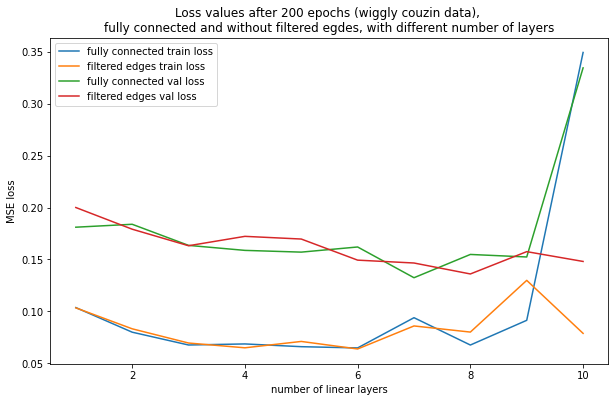

In [9]:
plt.figure(figsize=(10,6))
x = np.arange(1,11)
plt.plot(x,np.array(train_loss_list)[:, -1][::2], label="fully connected train loss")
plt.plot(x,np.array(train_loss_list)[:, -1][1::2], label="filtered edges train loss")
plt.plot(x,np.array(val_loss_list)[:, -1][::2], label="fully connected val loss")
plt.plot(x,np.array(val_loss_list)[:, -1][1::2], label="filtered edges val loss")
plt.legend()
plt.title("Loss values after 200 epochs (wiggly couzin data), \nfully connected and without filtered egdes, with different number of layers")
plt.xlabel("number of linear layers")
plt.ylabel("MSE loss")
plt.show()

# Edge Prediction

In [6]:
from SwarmNet import Edgeweight_SwarmNet

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses, val_losses, epochs = train_SwarmNet(model, optimizer, train_loader, val_loader,
                                                  criterion, epochs=500, device=device)


[Train: 0.047][Val: 0.106]: 100%|████████████| 500/500 [43:03<00:00,  5.17s/it]


In [8]:
PATH = "pascal_edge_prediction.pth"
save_model(model=model, optimizer=optimizer, epoch=epochs, train_losses=train_losses, val_losses=val_losses, path=PATH)

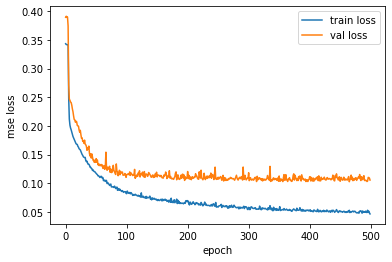

In [9]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("mse loss")
plt.legend()
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = "pascal_edge_prediction.pth"
model = Edgeweight_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, PATH)

RuntimeError: Error(s) in loading state_dict for Edgeweight_SwarmNet:
	Missing key(s) in state_dict: "edge_weighter1.weight", "edge_weighter1.bias", "edge_weighter2.weight", "edge_weighter2.bias". 

In [11]:
for data in val_loader:
    data = data.to(device)
    edge_weights = model.get_edge_weights(data.pose, data.view, data.edge_index)
    print(data.pose.shape)
    print(edge_weights.shape)
    break

torch.Size([640, 3])
torch.Size([640])


In [13]:
data.edge_index

tensor([[  0,   1,   2,  ..., 637, 638, 639],
        [  1,   0,   3,  ..., 636, 639, 638]], device='cuda:0')

In [14]:
data.pose[::2, :2].shape

torch.Size([320, 2])

In [19]:
data.pose[:2:2,None, :2], data.pose[1:2:2,None, :2]

(tensor([[[-30.1804,   0.9896]]], device='cuda:0'),
 tensor([[[ 20.3708, -22.4803]]], device='cuda:0'))

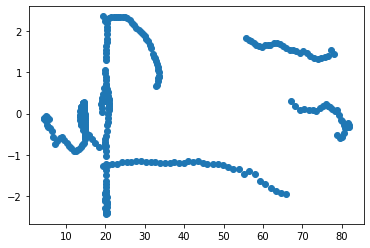

In [28]:
plt.scatter(torch.cdist(data.pose[::2,None, :2], data.pose[1::2,None, :2], p=2.0).flatten().cpu().detach().numpy(),
        (edge_weights[1::2] - edge_weights[::2] ).cpu().detach().numpy())
plt.show()

In [23]:
torch.cdist(data.pose[::2,None, :2], data.pose[1::2,None, :2], p=2.0).flatten()

tensor([55.7339, 56.3471, 56.9805, 57.6334, 58.3052, 58.9953, 59.7029, 60.4275,
        61.1686, 61.9254, 62.6974, 63.4841, 64.2849, 65.0993, 65.9268, 66.7669,
        67.6192, 68.4831, 69.3583, 70.2444, 71.1408, 72.0474, 72.9635, 73.8863,
        74.8023, 75.7007, 76.5725, 77.3944, 78.1561, 78.8504, 79.4728, 80.0204,
        80.4926, 80.8898, 81.2135, 81.4659, 81.6499, 81.7373, 81.7340, 81.6464,
        81.4814, 81.2462, 80.9478, 80.5934, 80.1898, 79.7436, 79.2610, 78.7481,
        78.2104, 77.6532, 77.0814, 76.4995, 75.9119, 75.2232, 74.4410, 73.5733,
        72.6286, 71.6152, 70.5415, 69.4152, 68.2439, 67.0345, 65.7936, 64.5272,
        63.2406, 61.9390, 60.6267, 59.2969, 57.9527, 56.5967, 55.2314, 53.8589,
        52.4992, 51.1533, 49.8223, 48.5074, 47.2100, 45.9316, 44.6737, 43.4382,
        42.2271, 41.0424, 39.8866, 38.7183, 37.5388, 36.3493, 35.1511, 33.9456,
        32.7339, 31.5175, 30.2976, 29.0756, 27.8532, 26.6318, 25.4133, 24.1996,
        22.9928, 21.7955, 20.6106, 19.44

In [24]:
edge_weights[1::2] - edge_weights[::2] 

tensor([ 1.8180,  1.7769,  1.7516,  1.7094,  1.6575,  1.6267,  1.6048,  1.6623,
         1.6555,  1.6485,  1.7085,  1.7007,  1.6764,  1.6234,  1.5843,  1.5449,
         1.5456,  1.5039,  1.4517,  1.5165,  1.4609,  1.3949,  1.3410,  1.3286,
         1.3403,  1.3660,  1.3938,  1.5417,  1.4424, -0.5157, -0.5941, -0.5703,
        -0.4685, -0.3597, -0.3348, -0.3067, -0.3248, -0.2863, -0.3227, -0.2692,
        -0.2328, -0.2763, -0.2459, -0.2680, -0.1817, -0.1573, -0.0368,  0.0909,
         0.0564,  0.1140,  0.1621,  0.1786,  0.2275,  0.1768,  0.1268,  0.0672,
         0.0861,  0.0924,  0.1178,  0.0977,  0.1913,  0.3093, -1.9474, -1.9287,
        -1.8608, -1.7971, -1.7032, -1.6272, -1.4590, -1.3851, -1.4676, -1.3441,
        -1.3280, -1.2932, -1.2343, -1.2155, -1.2115, -1.2072, -1.1927, -1.1529,
        -1.1594, -1.1488, -1.1891, -1.2050, -1.1741, -1.1853, -1.1910, -1.1841,
        -1.1774, -1.1706, -1.1599, -1.1569, -1.1561, -1.1575, -1.1603, -1.1719,
        -1.2177, -1.2257, -1.2343, -1.26

## Load Checkpoint

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=128, out_channels=1, 
                               conv_channels=3, conv_width=150, n_linear_layers=n_linears).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

PATH = ""
epoch, prev_train_losses, prev_val_losses = load_model(model, optimizer, path=PATH)

model.eval()

# Build Fish Model from Torch Model

In [42]:
model.eval()
model.to("cpu")
raymodel = CouzinModel(model=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=10)

100%|███████████████████████████████████████| 199/199 [00:01<00:00, 155.46it/s]


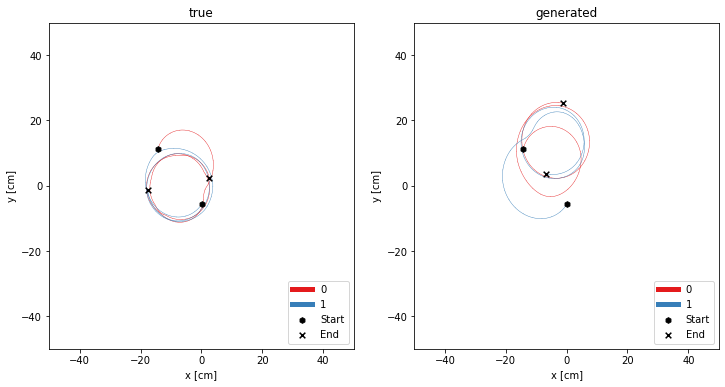

In [43]:
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
f = generator.as_io_file(swarm_poses[0,:n,:,:])
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=2, trackset_len=swarm_poses.shape[2], initial_poses=swarm_poses[0,:n,0,:])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.show()

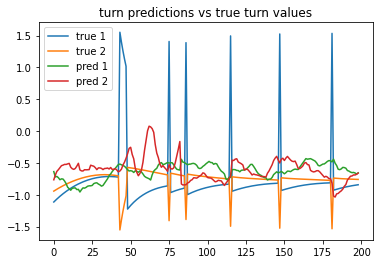

In [26]:
# 1 layer
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.title("turn true turn values")
plt.legend()
plt.show()
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.title("turn predicted turn values")
plt.legend()
plt.show()

100%|███████████████████████████████████████| 199/199 [00:00<00:00, 213.29it/s]


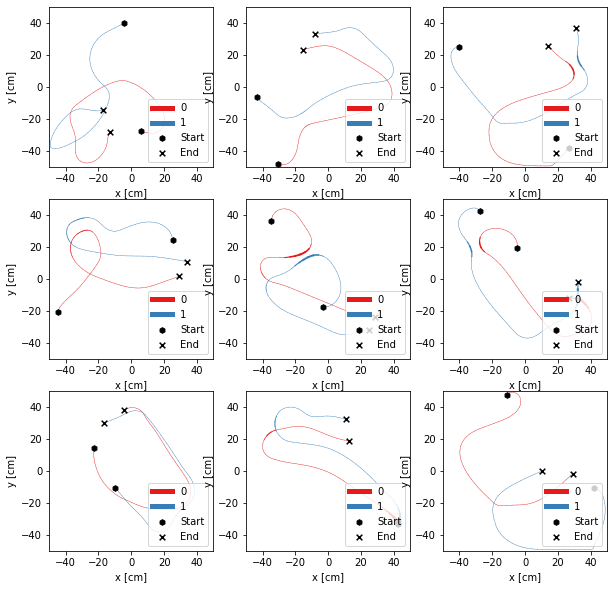

In [27]:
# 1 layer
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=2, trackset_len=swarm_poses.shape[2])
        f = generator.as_io_file(track)
        f.plot(lw_distances=True, ax=axs[i,j])
plt.show()

# Overarching Evaluation

In [28]:
paths = []
labels = []
model_path = r"D:\ResearchInternshipData\pascal_data_edge_filter1"
model_label = "1 layer Model Data"
for i in range(200):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\pascal_data_edge_filter1\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 199/199 [00:00<00:00, 209.85it/s]


In [46]:
paths = []
labels = []
model_path2 = r"D:\ResearchInternshipData\pascal_data_edge_filter3"
model_label2 = "3 layer Model Data"
for i in range(200):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\pascal_data_edge_filter3\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 199/199 [00:01<00:00, 157.79it/s]


In [67]:
# for i, pose in enumerate(swarm_poses[:,:,:,:]):
#     f = generator.as_io_file(pose, r"D:\ResearchInternshipData\pascal_train\file_" + str(i) + ".hdf5")
#     f.close()

In [29]:
import robofish.evaluate.evaluate as robo_eval

In [31]:
# f1 = r"D:\ResearchInternshipData\pascal_train"
f1 = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\fish_models\storage\raw_data\pascal_vanilla_couzin\2fish_200t_10hz_vanilla\train"

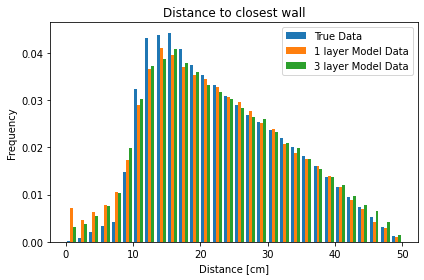

In [47]:
robo_eval.evaluate_distance_to_wall([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

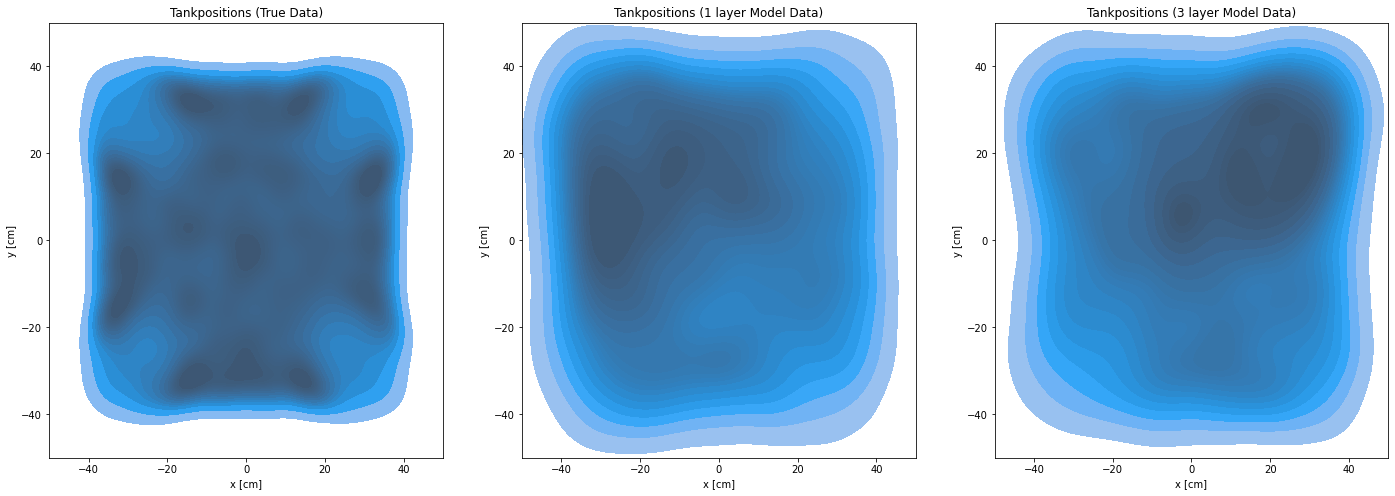

In [48]:
robo_eval.evaluate_tank_position([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

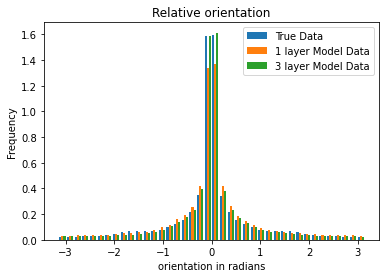

In [49]:
robo_eval.evaluate_relative_orientation([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

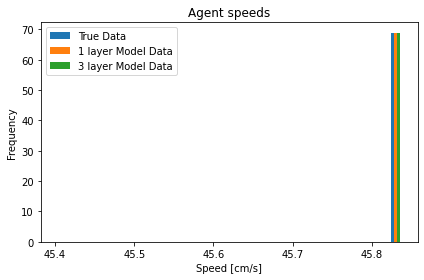

In [50]:
robo_eval.evaluate_speed([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

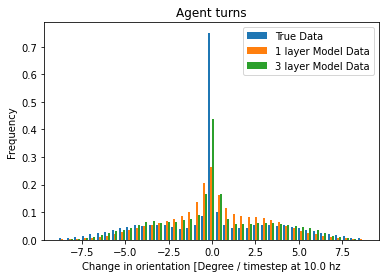

In [51]:
robo_eval.evaluate_turn([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

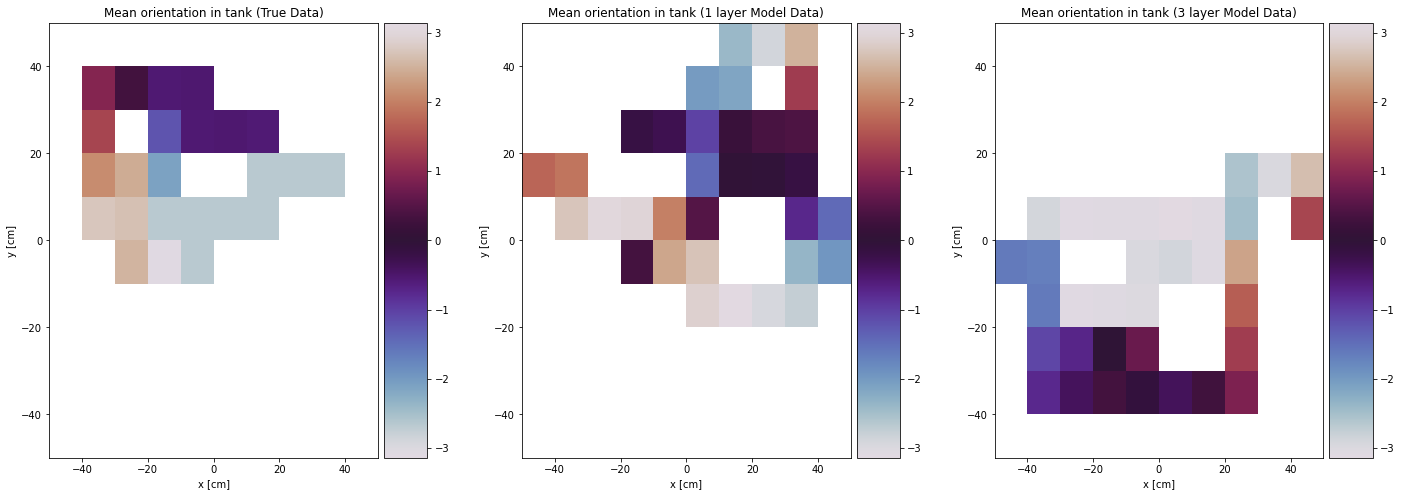

In [52]:
robo_eval.evaluate_orientation([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.show()

<Figure size 576x576 with 0 Axes>

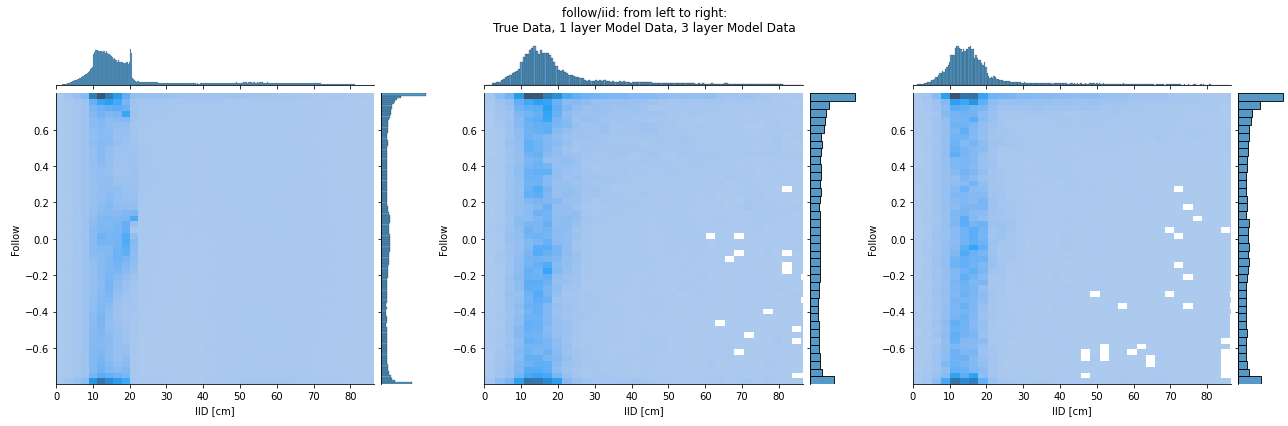

In [53]:
plt.figure(figsize=(8,8))
robo_eval.evaluate_follow_iid([f1, model_path, model_path2], ["True Data", model_label, model_label2])
plt.tight_layout()
plt.show()